In [1]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN
%load_ext autoreload
%autoreload 2


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy
print (tf.__version__)
# Notes about version:
# - 1.10+ has a problem with DeepExplain, in particular evaluating any tensor in maxpool_grad_override hangs
# - 1.9 does not show the problem above

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain, ProbMaxPooling2D, ProbDense, ProbConv2D, ProbFlatten, ProbActivationRelu, ProbConv2DInput

#Import DeepLift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func
print (deeplift)

Using TensorFlow backend.


1.10.1
<module 'deeplift' from '/usr/local/lib/python3.6/dist-packages/deeplift/__init__.py'>


In [3]:
#K.clear_session()

In [4]:
# Build and train a network.

SKIP_TRAIN = True
saved_model_file = 'model_cnn.h5'
saved_model_weights_file = 'model_cnn_w.h5'

batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_train])
x_test = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_test])



x_train = x_train.reshape(-1, img_rows,img_cols,1)
x_test = x_test.reshape(-1, img_rows,img_cols,1)
#x_train = x_train.reshape(-1, img_rows*img_cols)
#x_test = x_test.reshape(-1, img_rows*img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
reg = keras.regularizers.l1(0)
def f(x):
    return x*tf.sigmoid(x)


#de.enable_override('shapley')

model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5),activation='relu',input_shape=x_train.shape[1:], name='conv_1'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (5, 5), activation='relu', name='conv_2'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(32, kernel_size=(4, 4),activation='relu',input_shape=x_train.shape[1:]))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(120, activation='relu', name='dense_1'))
model.add(Dense(84, activation='relu', name='dense_2'))
model.add(Dense(num_classes, name='dense_3'))
model.add(Activation('softmax'))
# ^ IMPORTANT: notice that the final softmax must be in its own layer 
# if we want to target pre-softmax units

if SKIP_TRAIN is True:
    model.load_weights(saved_model_weights_file)
else:  
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    model.save_weights(saved_model_weights_file)

    #print (model.layers[0].get_weights()[1].mean())
    #print (model.layers[0].get_weights()[1].var())
model.summary()   
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
_________________________________________________________________
den

In [5]:
# Define what to be explained
xs = x_test[0:10]
ys = y_test[0:10]

a_gradin = np.zeros_like(xs)
a_intgrad = np.zeros_like(xs)
a_res = np.zeros_like(xs)
a_rc = np.zeros_like(xs)
a_shap = np.zeros_like(xs)
a_exact = np.zeros_like(xs)

In [6]:
%%time
n = xs.shape[0]
n_classes = 10

# Create input layer out of first conv layer
conv1 = ProbConv2DInput(model.layers[0], xs.shape)
# Run it once to get the output shape
hidden1_shape = conv1(xs, 0, 0).shape
print (hidden1_shape)

# Create an equivalent probabilistic model. Notice that
# 1. The (probabilistic) input has one more dimension to include both mean and variance
# 2. We only keep the non-linearity of the original first dense layer (because the probabilistic input will be computed aside)
probInput = Input(shape=(hidden1_shape[1:-1] + (2,)))
y = ProbActivationRelu()(probInput)
y = ProbMaxPooling2D(pool_size=(2, 2))(y)
y = ProbConv2D(16, (5, 5), activation='relu', name='conv_2')(y)
y = ProbMaxPooling2D(pool_size=(2, 2))(y)
y = ProbFlatten()(y)
y = ProbDense(120, activation='relu', name='dense_1')(y)
y = ProbDense(84, activation='relu', name='dense_2')(y)
y = ProbDense(num_classes, name='dense_3')(y)
probModel = Model(inputs=probInput, outputs=y)
# ... and load weights in it
probModel.load_weights(saved_model_weights_file, by_name=True)
probModel.summary()
# Implement loop to estimate shapley values
# Params
xn = 10

# Flatten MNIST input
x = np.copy(xs)
n_input_feat = np.prod(x.shape[1:])
# Prepare array for output
result = np.zeros((n, n_input_feat, n_classes))
# Define sub-coalition sizes
Ks = range (0, n_input_feat, max(1, n_input_feat//xn))


sess = K.get_session()
for j in range(n_input_feat):
    for ki in range(len(Ks)):
        k = Ks[ki] # coalition size
    
        probInput = conv1(x, k, j)
        #print (probInput)
        mu1 = probInput[..., 0]
        mu2 = probInput[..., 1]
        v1 = probInput[..., 2]
        v2 = probInput[..., 3]
        
        x1 = np.stack([mu1, v1], -1)
        x2 = np.stack([mu2, v2], -1)
        out1 = probModel.predict(x1)
        out2 = probModel.predict(x2)
        eshap = ((out2[..., 0] - out1[..., 0]) / len(Ks))
        result[:, j, :] += eshap

print (result.shape)
print (np.argmax(ys, 1).shape)
a_shap = np.array([result[i, :, c] for i, c in enumerate(np.argmax(ys, 1))])
a_shap = a_shap.reshape(x.shape)
print (a_shap.shape)
print ('Done')


set result
(10, 24, 24, 6, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 24, 6, 2)      0         
_________________________________________________________________
prob_activation_relu_1 (Prob (None, 24, 24, 6, 2)      0         
_________________________________________________________________
prob_max_pooling2d_1 (ProbMa (None, 12, 12, 6, 2)      0         
_________________________________________________________________
conv_2 (ProbConv2D)          (None, 8, 8, 16, 2)       2416      
_________________________________________________________________
prob_max_pooling2d_2 (ProbMa (None, 4, 4, 16, 2)       0         
_________________________________________________________________
prob_flatten_1 (ProbFlatten) (None, 256, 2)            0         
_________________________________________________________________
dense_1 (ProbDense)          (None, 120, 2)   

In [7]:
print (a_shap[0])

[[[-8.93109212e-04]
  [-1.49823724e-03]
  [-3.08735667e-03]
  [-3.29604614e-03]
  [ 6.99498425e-04]
  [ 3.79957932e-03]
  [ 5.27568701e-03]
  [ 6.39394869e-03]
  [ 5.13584100e-03]
  [ 4.41594554e-03]
  [ 2.53000588e-03]
  [ 1.33093112e-03]
  [ 1.24708907e-03]
  [ 1.98089670e-03]
  [ 1.36414036e-03]
  [ 1.45105200e-03]
  [ 6.65237958e-04]
  [ 3.87768818e-04]
  [-2.19886955e-04]
  [ 1.52724709e-04]
  [ 1.40798764e-03]
  [ 1.82868809e-03]
  [ 2.06340442e-03]
  [ 2.38502701e-03]
  [ 3.02846999e-03]
  [ 2.36970859e-03]
  [ 2.74481836e-03]
  [ 2.48521027e-03]]

 [[-3.71049759e-04]
  [-4.68466764e-04]
  [-1.31316619e-03]
  [ 5.50356740e-04]
  [ 4.06672881e-03]
  [ 8.08811739e-03]
  [ 6.78441883e-03]
  [ 5.31891264e-03]
  [ 2.11599201e-03]
  [-4.14649277e-04]
  [ 1.09834020e-03]
  [ 5.00454822e-03]
  [ 7.95517046e-03]
  [ 1.34568824e-02]
  [ 1.68243630e-02]
  [ 1.70039264e-02]
  [ 1.57226959e-02]
  [ 1.49643137e-02]
  [ 1.07249322e-02]
  [ 9.40206642e-03]
  [ 7.45655197e-03]
  [ 6.39810070e-03

In [8]:
%time
input_tensor = model.layers[0].input
grad_original = xs * K.gradients(model.layers[-2].output*ys, [input_tensor])[0]
max_pool_grad_original = K.function([input_tensor], [grad_original])([xs])[0]
print (max_pool_grad_original.shape)

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    

    
    a_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    #a_res = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    #a_rc2 = de.explain('deeplift_rc', target_tensor * ys, input_tensor, xs)
    #a_linear = de.explain('linear', target_tensor * ys, input_tensor, xs)
    #a_shap = de.explain('shapley', target_tensor * ys, input_tensor, xs)
    #a_shap = np.zeros_like(a_linear)
    
    #attributions2 = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print ("Done")
print (max_pool_grad_original[0])
print ('Override')
print (a_shap[0])
print (np.sum((max_pool_grad_original - a_shap)**2))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs
(10, 28, 28, 1)
DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
maxpool: original gradient
conv: original grad
maxpool: original gradient
conv: original grad
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
maxpool: original gradient
conv: original grad
maxpool: original gradient
conv: original grad
Done
[[[ 1.19119156e-02]
  [-4.68623871e-03]
  [ 8.55691917e-03]
  [ 1.31739760e-02]
  [-1.44916885e-02]
  [ 2.16233381e-03]
  [-2.24116463e-02]
  [ 2.33854493e-03]
  [ 8.38482752e-03]
  [-1.18115824e-02]
  [ 6.86941110e-03]
  [-1.72298029e-02]
  [-8.16436112e-03]
  [-4.54212539e-03]
  [-1.54424533e-02]
  [-3.43447318e-04]
  [ 1.44241517e-03]
  [-2.39946246e-02]
  [ 1.89223755e-02]
  [-1.01559423e-02]
  [ 1.90423205e-02]
  [-5.19822491e-03]
  [-3.70872137e-03]
  [ 5.13195898e-03]
  [ 1.62586884e-03]
  [-2.26739096e-03]
  [ 5.17607480e-03]
  [-0.

In [9]:
# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

    
    
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_res = np.array([np.array(rescale_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])
print (a_rc.shape)

nonlinear_mxts_mode is set to: RevealCancel
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
nonlinear_mxts_mode is set to: Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
(10, 1, 28, 28, 1)


In [10]:
print (keras.__version__)

2.2.0


In [11]:
#%%script false
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]#.mean(0, keepdims=True)
#background = np.zeros_like(background)

# explain predictions of the model on four images
e = shap.GradientExplainer((model.layers[0].input, model.layers[-2].output), background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(xs)
y_ = np.argmax(ys, 1)
npshap = np.array(shap_values)
#npshap = npshap.reshape(10, 15, -1)
#shap_values = np.transpose(shap_values, (1, 0, 2, 3, 4))
a_shaplud = np.array([npshap[item, enum] for enum, item in enumerate(y_)])
print (a_shaplud.shape)

# plot the feature attributions
#shap.image_plot(shap_values, -xs)

(10, 28, 28, 1)


In [12]:

# Compute exacly shapley values!
saved_file = 'exact.npy'

def model_fun(y) :
    def f(x):
        _x = x.reshape((x.shape[0],)+xs.shape[1:])
        return (fModel.predict(np.array(_x))*y).sum(-1)
    return f

def model_in(x):
    return x.flatten()
    
    
if True or not SKIP_TRAIN:
    from deepexplain.tensorflow.exact_shapley import compute_shapley
    a_exact = np.array([compute_shapley(model_in(xx), model_fun(yy)) for xx, yy in zip(xs, ys)])
    np.save(saved_file, a_exact)
else:
    a_exact = np.load(saved_file)


ValueError: Maximum allowed size exceeded

Text(0.5, 1.0, 'Exact Shap')

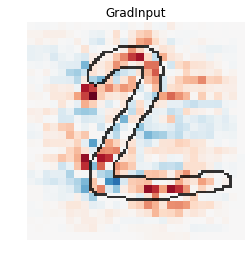

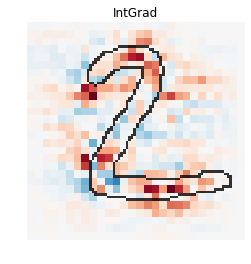

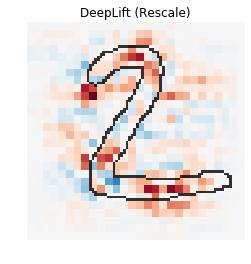

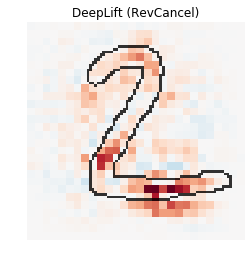

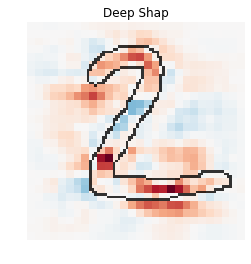

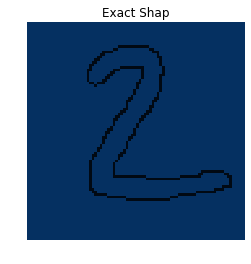

In [20]:
# Plot attributions
from utils import plot, plt
%matplotlib inline
idx = 1
plot(a_gradin[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('GradInput')
plt.figure()
plot(a_intgrad[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('IntGrad')
plt.figure()
plot(a_res[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('DeepLift (Rescale)')
plt.figure()
#plot((a_linear)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Linear')
#plt.figure()
plot(a_rc[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('DeepLift (RevCancel)')
plt.figure()
plot((a_shap)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Deep Shap')
plt.figure()
plot((a_exact)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Exact Shap')




        
        


In [ ]:
methods = [a_gradin, a_intgrad, a_res, a_rc, a_shap, a_exact]
confusion = np.zeros((len(methods), len(methods)))
confusion[:] = np.nan
confusion_r = np.zeros((len(methods), len(methods)))
confusion_r[:] = np.nan

n = a_gradin.shape[0]
for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        if i >= j:
            m1 = m1.reshape(n, -1)
            m2 = m2.reshape(n, -1)
            confusion[i][j] = ((m1-m2)**2).mean()
            confusion_r[i][j] = np.mean([scipy.stats.spearmanr(x, y)[0] for x,y in zip(m1, m2)])
plt.figure()
plt.matshow(confusion, cmap='RdBu_r')
plt.colorbar()
plt.figure()
plt.matshow(confusion_r, cmap='RdBu_r')
plt.colorbar()
print ('Diff with DeepShap ', confusion[-1][-2])
print ('Diff with DeepLift ', confusion[-1][-3])
print ('Diff with DeepLift (Rescale) ', confusion[-1][-4])
print ('Diff with Int Gradients ', confusion[-1][-5])
print ('Diff with GradInput ', confusion[-1][-6])


print ('Pearson with DeepShap ', confusion_r[-1][-2])
print ('Pearson with DeepLift ', confusion_r[-1][-3])
print ('Pearson with DeepLift (rescale)', confusion_r[-1][-4])
print ('Pearson with Int Gradients ', confusion_r[-1][-5])
print ('Pearson with GradInput ', confusion_r[-1][-6])

In [16]:
from deepexplain.tensorflow.accuracy_robustness import run_robustness_test
original_maps = [a_gradin, a_intgrad, a_res, a_rc, a_shap]
names = ['GradInput', 'IntGrad', 'DeepLift (Recale)', 'DeepLift (RevCanc)', 'Deep Shapley']
run_robustness_test(fModel, xs, ys, original_maps, names, 'Test', 1,
                        result_path='.', mode='prediction', reduce_dim=None)



Running robustness test...
Storing robustness results...
Done
